# Using the Berkeley [Loadshape](https://bitbucket.org/berkeleylab/eetd-loadshape) library for regression features and to fill gaps

- Clayton Miller (miller.clayton@gmail.com)
- http://datadrivenbuilding.org/

We will use the techniques in LoadShape to:
- Fill gaps in the data
- Create a set of regression features for characterization

In [2]:
from loadshape import Loadshape

In [70]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import timeit
import os
from datetime import datetime
from __future__ import division

In [6]:
sns.set_style("whitegrid")

In [7]:
%matplotlib inline

First, get the raw data:

In [8]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [9]:
temp = pd.read_csv(os.path.join(repos_path,"data/raw/temp_open.csv"), index_col="timestamp", parse_dates=True)

In [10]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid')

## First, let's just test one building to understand the library's output and how it works

In [11]:
testbuilding = "UnivClass_Abby"

In [12]:
test_start = meta.T[testbuilding].datastart
test_end = meta.T[testbuilding].dataend
test_building_data = pd.DataFrame(temp[testbuilding].truncate(before=test_start,after=test_end))

In [13]:
test_building_data.head()

,UnivClass_Abby
timestamp,
2015-01-01 00:00:00,23.74
2015-01-01 01:00:00,23.70
2015-01-01 02:00:00,23.93
2015-01-01 03:00:00,24.89
2015-01-01 04:00:00,23.61


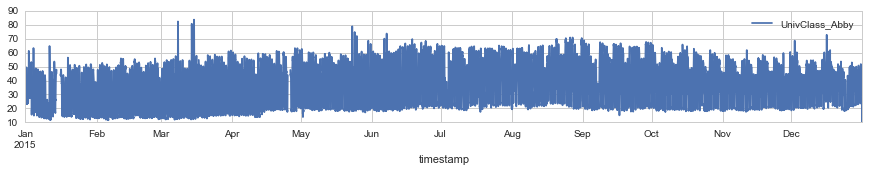

In [14]:
test_building_data.plot(figsize=(15,2));

In [15]:
weatherfilename = meta.T[testbuilding].newweatherfilename

In [16]:
test_weather = pd.read_csv(os.path.join(repos_path,"data/external/weather/"+weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')

In [17]:
outdoor_temp = pd.DataFrame(test_weather[[col for col in test_weather.columns if 'Temperature' in col]])

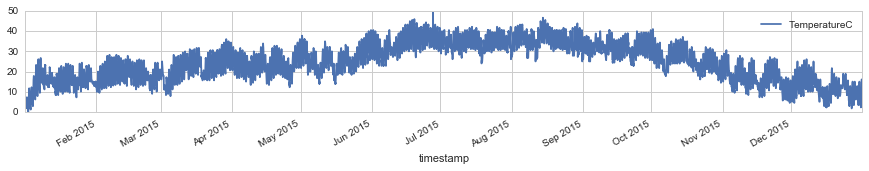

In [18]:
outdoor_temp.plot(figsize=(15,2));

In [19]:
def create_loadshapeinput_format(df, colname):
    inputdata = []
    for x, y in zip(df.index.format('%Y-%m-%d %H:%M:%S.%f')[1:], df[colname]):
        inputdata.append((x,y))
    return inputdata

In [20]:
timezone = meta.T[testbuilding].timezone

In [21]:
actual = create_loadshapeinput_format(test_building_data, testbuilding)
actual_weather = create_loadshapeinput_format(outdoor_temp, "TemperatureC")

In [22]:
loadshapemodel = Loadshape(actual, actual_weather, timezone=timezone, temp_units="C")

In [31]:
predicted = loadshapemodel.baseline().data()

In [32]:
predicted = pd.DataFrame(predicted)
predicted.index = pd.to_datetime(predicted[0], unit="s")
predicted = pd.DataFrame({testbuilding+'_predicted':predicted.tz_localize('UTC').tz_convert(timezone)[1]})

In [33]:
predicted.head()

,UnivClass_Abby_predicted
0,
2015-01-01 00:00:00-07:00,21.93
2015-01-01 00:15:00-07:00,21.93
2015-01-01 00:30:00-07:00,21.93
2015-01-01 00:45:00-07:00,21.93
2015-01-01 01:00:00-07:00,21.93


In [35]:
#test_building_data = test_building_data.tz_localize(timezone)

In [36]:
#predicted = predicted.resample("H")

In [37]:
combined = pd.merge(predicted, test_building_data, right_index=True, left_index=True)

In [38]:
combined.columns = ["Actual","Predicted"]
combined.head()

,Actual,Predicted
2015-01-01 00:00:00-07:00,21.93,23.74
2015-01-01 01:00:00-07:00,21.93,23.70
2015-01-01 02:00:00-07:00,23.36,23.93
2015-01-01 03:00:00-07:00,24.01,24.89
2015-01-01 04:00:00-07:00,24.13,23.61


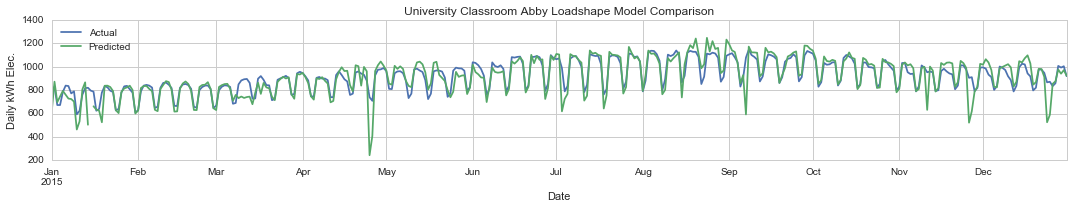

In [42]:
combined.resample('D').sum().plot(figsize=(15,3))
plt.xlabel("Date")
plt.ylabel("Daily kWh Elec.")
plt.title("University Classroom Abby Loadshape Model Comparison")
plt.tight_layout()
plt.savefig(os.path.join(repos_path,"reports/figures/loadshape/predictedvsactual_annual_abby.png"));

One can see that in the third week of May, there is a dip in the actual vs. predicted. This is due to missing data. If we zoom in:

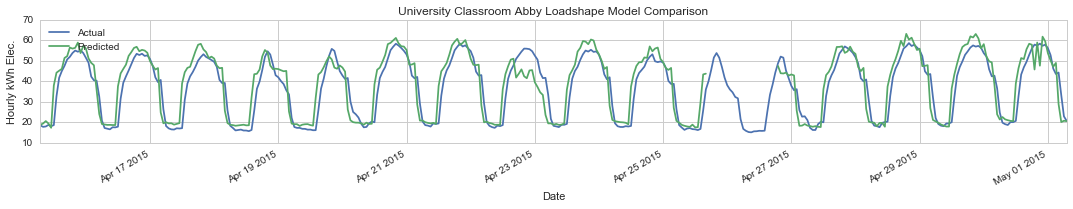

In [43]:
combined.truncate(before='2015-04-15',after='2015-05').plot(figsize=(15,3))
plt.xlabel("Date")
plt.ylabel("Hourly kWh Elec.")
plt.title("University Classroom Abby Loadshape Model Comparison")
plt.tight_layout()
plt.savefig(os.path.join(repos_path,"reports/figures/loadshape/predictedvsactual_zoomin_abby.png"));

In [45]:
predicted.resample('H').mean().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Freq: H
Data columns (total 1 columns):
UnivClass_Abby_predicted    8760 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


In [46]:
errors = pd.DataFrame({testbuilding:loadshapemodel.error_stats})

In [47]:
errors

,UnivClass_Abby
corr_hour,0.949
corr_interval,0.949
corr_interval_daytime,0.825
mape_hour,9.694
mape_interval,9.694
mape_interval_daytime,9.097
rmse_hour,4.863
rmse_interval,4.863
rmse_interval_daytime,5.619


In [48]:
test_building_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Data columns (total 1 columns):
UnivClass_Abby    8690 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


In [49]:
test_building_data_predicted = predicted.resample("H").mean()

In [50]:
test_building_data_predicted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Freq: H
Data columns (total 1 columns):
UnivClass_Abby_predicted    8760 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


As you can see, the test_building_actual has 8690 points and the predicted has 8760. We will use the pandas ".update" function to overlay the predicted onto the actual and replace ONLY the NaN values.

In [51]:
test_building_data_predicted.columns = [testbuilding]

In [52]:
test_building_data.update(test_building_data_predicted, overwrite=False)

In [53]:
test_building_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Data columns (total 1 columns):
UnivClass_Abby    8760 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


In [54]:
test_building_data_predicted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Freq: H
Data columns (total 1 columns):
UnivClass_Abby    8760 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


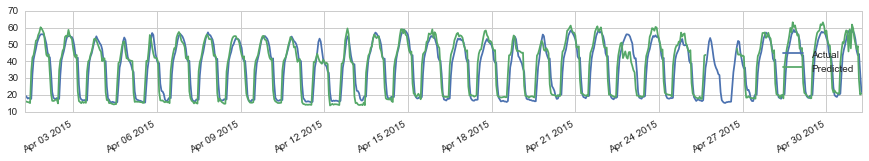

In [55]:
combined.truncate(before='2015-04',after='2015-05').plot(figsize=(15,2));

You can see the gap above and how its filled below

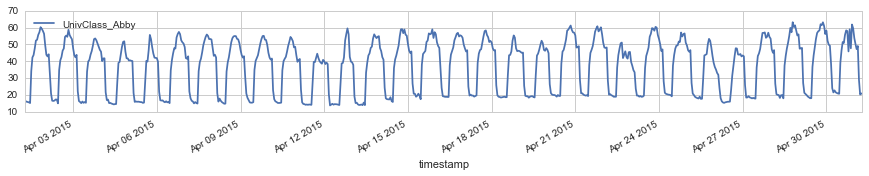

In [56]:
test_building_data.truncate(before='2015-04',after='2015-05').plot(figsize=(15,2));

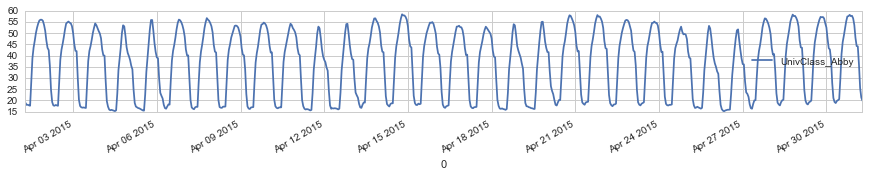

In [57]:
test_building_data_predicted.truncate(before='2015-04',after='2015-05').plot(figsize=(15,2));

In [155]:
test_building_data_predicted.truncate(after="2015-11-02")#.tz_localize(None)

,UnivClass_Abby
0,
2015-01-01 00:00:00-07:00,21.9300
2015-01-01 01:00:00-07:00,23.0025
2015-01-01 02:00:00-07:00,23.8475
2015-01-01 03:00:00-07:00,24.1000
2015-01-01 04:00:00-07:00,24.2875
2015-01-01 05:00:00-07:00,31.7875
2015-01-01 06:00:00-07:00,30.5500
2015-01-01 07:00:00-07:00,31.8825
2015-01-01 08:00:00-07:00,34.2775


Now, test_building_data is filled in with the model data

In [58]:
test_building_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00-07:00 to 2015-12-31 23:00:00-07:00
Data columns (total 1 columns):
UnivClass_Abby    8760 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


## Get the residuals

In [59]:
residuals = test_building_data - test_building_data_predicted

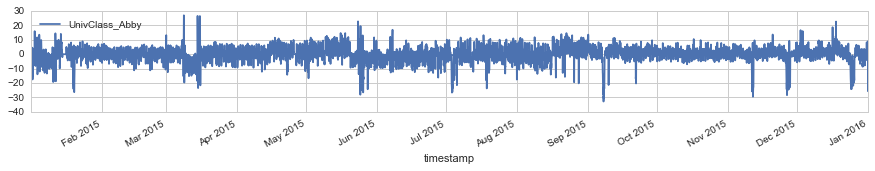

In [60]:
residuals.plot(figsize=(15,2));

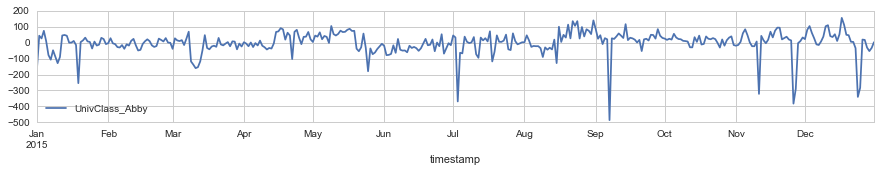

In [63]:
residuals.resample('D').sum().plot(figsize=(15,2));

Super stick problem with time zone converion: http://stackoverflow.com/questions/27068765/python-pandas-tz-localize-throws-nonexistenttimeerror-then-unable-to-drop-erron

In [86]:
def dst_mask(building_data, timezone):
    if timezone in set(["America/Chicago","America/Los_Angeles","America/New_York", "Europe/Zurich"]):
        mask = ((building_data.index<datetime.strptime("2015-03-08 02:00:00","%Y-%m-%d %H:%S:%M")) | (building_data.index>datetime.strptime("2015-03-08 02:00:00","%Y-%m-%d %H:%S:%M"))) & (
            (building_data.index<datetime.strptime("2013-03-31 02:00:00","%Y-%m-%d %H:%S:%M")) | (building_data.index>datetime.strptime("2013-03-31 02:00:00","%Y-%m-%d %H:%S:%M"))) & (
            (building_data.index<datetime.strptime("2012-03-11 02:00:00","%Y-%m-%d %H:%S:%M")) | (building_data.index>datetime.strptime("2012-03-11 02:00:00","%Y-%m-%d %H:%S:%M"))) & (
            (building_data.index<datetime.strptime("2010-03-14 02:00:00","%Y-%m-%d %H:%S:%M")) | (building_data.index>datetime.strptime("2010-03-14 02:00:00","%Y-%m-%d %H:%S:%M"))) 
        return building_data[mask]
    elif timezone in set(["Europe/London"]):
        mask = ((building_data.index<datetime.strptime("2015-03-29 01:00:00","%Y-%m-%d %H:%S:%M")) | (building_data.index>datetime.strptime("2015-03-29 02:00:00","%Y-%m-%d %H:%S:%M"))) 
        return building_data[mask]
    else:
        return building_data

Below code is to test dst_mask

In [173]:
building = "Office_Payton"
start = meta.T[building].datastart
end = meta.T[building].dataend
building_data = pd.DataFrame(temp[building].truncate(before=start,after=end))
#timezone = meta.T[building].timezone
#building_data = dst_mask(building_data, timezone)
building_data = building_data.tz_localize("US/Eastern", ambiguous="infer")#.tz_convert("UTC")

AmbiguousTimeError: Cannot infer dst time from 2015-11-01 01:00:00 asthere are no repeated times

In [162]:
#building_data.truncate(before="2015-03-08")

In [126]:
#building_data.resample("H").mean()#.truncate(before='2015-03-08')

In [136]:
#building_data.resample("H").mean()

In [141]:
rng = pd.date_range('1/1/2015 00:00', periods=8760, freq='H')

In [142]:
ts = pd.Series(np.random.randn(len(rng)), rng)


In [143]:
ts.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='H')

In [145]:
ts_utc = ts.tz_localize('UTC')

In [165]:
#ts_eastern = ts_utc.tz_convert('US/Eastern')

In [164]:
#ts_easter.resample("W").mean()

In [163]:
#ts_eastern

# Loop through all buildings and run load shape model

In [129]:
def runloadshapemodel(meta, temp, building):
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    building_data = pd.DataFrame(temp[building].truncate(before=start,after=end))
    weatherfilename = meta.T[building].newweatherfilename
    
    weather = pd.read_csv(os.path.join(repos_path,"data/external/weather/"+weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')
    outdoor_temp = pd.DataFrame(weather[[col for col in test_weather.columns if 'Temperature' in col]])

    timezone = meta.T[building].timezone
    
    building_data_actual = create_loadshapeinput_format(building_data, building)
    actual_weather = create_loadshapeinput_format(outdoor_temp, "TemperatureC")
    loadshapemodel = Loadshape(actual, actual_weather, timezone=timezone, temp_units="C")
    
    building_data_predicted = loadshapemodel.baseline().data()
    building_data_predicted = pd.DataFrame(building_data_predicted)
    building_data_predicted.index = pd.to_datetime(building_data_predicted[0], unit="s")
    building_data_predicted = pd.DataFrame({building+'_predicted':building_data_predicted.tz_localize('UTC').tz_convert(timezone)[1]})
    
    errors = pd.DataFrame({building:loadshapemodel.error_stats})
    
    building_data_predicted = building_data_predicted.resample("H")
    building_data_predicted.columns = [building]
    
    building_data = dst_mask(building_data, timezone)
    building_data = building_data.tz_localize(timezone, ambiguous='NaT')
    
    building_data.update(building_data_predicted, overwrite=False)
    
    residuals = building_data - building_data_predicted
    
    return errors, building_data, building_data_predicted, residuals

In [130]:
errors, building_data, building_data_predicted, residuals = runloadshapemodel(meta, temp, "UnivLab_Molly")

In [131]:
errors

,UnivLab_Molly
corr_hour,0.956
corr_interval,0.956
corr_interval_daytime,0.795
mape_hour,10.157
mape_interval,10.157
mape_interval_daytime,9.444
rmse_hour,4.496
rmse_interval,4.496
rmse_interval_daytime,5.400


In [142]:
#building_data.to_csv("test.csv")

In [150]:
#building_data.tz_convert("UTC").resample('D',how='sum')#.plot(figsize=(15,2))
building_data_predicted.resample('D',how='sum').plot(figsize=(15,2));

NameError: name 'building_data_predicted' is not defined

In [145]:
residuals.resample('D',how='sum').plot(figsize=(15,2));

ValueError: Passed item and index have different timezone

In [151]:
#residuals.truncate(before="2014-11-01")